# Fundamentals walkthrough

This provides an overview of the basic calculations underlying the model:
- How to calculate caloric energy deficit
- How caloric deficits lead to changes in BMI (month-to-month)
- How low BMI leads translates to mortality estimates

These calculations are based on our understanding of the approach described in the Clingendael Institute report, ["From Hunger to Death"](https://www.clingendael.org/publication/sudan-hunger-death).


In [3]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math
import warnings
import matplotlib.pyplot as plt

try: # identify if in colab to fix paths
    import google.colab
    IN_COLAB = True
    print("colab identified.")
except ImportError:
    IN_COLAB = False

In [ ]:
# clone the repository to access the data
# unneeded here !git clone https://github.com/aristotle-tek/famine-prediction.git

In [2]:
# (unneeded here)
# if IN_COLAB: # fix for paths in colab
#     base_path = Path('/content/famine-prediction')
# else:
#     try:
#         base_path = Path(__file__).resolve().parent.parent
#     except NameError:
#         base_path = Path.cwd().parent.parent

In [7]:
# Here are some of the basic functions, recopied from `model_utils.py` for inspection

# Energy requirements based on BMI categories
energy_requirements = {
    "BMI < 15 kg/m²": 1900,
    "15 ≤ BMI < 18.5 kg/m²": 2100,
    "BMI ≥ 18.5 kg/m²": 2200
}

def calculate_energy_deficit(cereal_intake, bmi, energy_requirements, percent_grain=0.7):
    """
    Calculate the energy deficit or surplus as a fraction of the energy requirement.

    Args:
        cereal_intake (float): The cereal intake in kcal (must be positive).
        bmi (float): The current BMI of the individual.
        energy_requirements (dict): A dictionary of energy requirements based on BMI categories.
        percent_grain (float): The percentage of calories from grains (must be between 0 and 1, default is 0.7).

    Returns:
        float: The energy deficit (positive for deficit, negative for surplus) as a fraction of the energy requirement.
    """
    # Input validation
    if not isinstance(cereal_intake, (int, float)) or cereal_intake <= 0:
        raise ValueError("Cereal intake must be a positive number.")

    if not (10 <= bmi <= 60):
        raise ValueError("BMI should be in the range of 10 to 60.")

    if bmi < 15 or bmi > 30:
        warnings.warn("Warning: extreme values of BMI (<15 or >30).")

    if not isinstance(percent_grain, (int, float)) or not (0 < percent_grain <= 1):
        raise ValueError("Percent grain must be a number between 0 and 1.")

    # Validate energy requirements dictionary
    required_bmi_categories = [
        "BMI < 15 kg/m²",
        "15 ≤ BMI < 18.5 kg/m²",
        "BMI ≥ 18.5 kg/m²"
    ]
    if not all(category in energy_requirements for category in required_bmi_categories):
        raise ValueError("The energy requirements dictionary must contain all required BMI categories.")

    # Determine BMI category
    if bmi < 15:
        bmi_category = "BMI < 15 kg/m²"
    elif 15 <= bmi < 18.5:
        bmi_category = "15 ≤ BMI < 18.5 kg/m²"
    else:
        bmi_category = "BMI ≥ 18.5 kg/m²"

    # Calculate energy requirement and intake
    energy_requirement = energy_requirements[bmi_category]
    energy_intake = cereal_intake / percent_grain

    # Calculate energy deficit or surplus fraction
    deficit = (energy_requirement - energy_intake) / energy_requirement  # Positive for deficit, negative for surplus

    return deficit



def update_bmi(deficit, bmi_prev, recovery=False, factor_deficit=0.096):
    """
    Calculate the updated BMI based on energy deficit/surplus and previous BMI.

    Args:
        deficit (float): Energy deficit (positive for deficit, negative for surplus) as a fraction of the energy requirement.
        bmi_prev (float): The BMI of the previous month.
        recovery (bool): whether in recovery
        factor_deficit (float): Coefficient for BMI adjustment during deficit (default is 0.096).
        recovery_factor (float): Coefficient for BMI adjustment during recovery (?)

    Returns:
        float: The updated BMI for the current month.
    """
    # Input validation
    if not isinstance(deficit, (int, float)):
        raise ValueError("Deficit must be a number.")

    # if not (10 <= bmi_prev <= 60):
    #     raise ValueError("The previous BMI should be in the range of 10 to 60.")
    if not (bmi_prev <= 60):
        raise ValueError("The previous BMI should not exceed 60.")

    # Deficit case (recovery calc omitted for now)
    factor = factor_deficit
    delta_bmi = 3.0 * deficit - factor * (22 - bmi_prev)

    bmi_new = bmi_prev - delta_bmi

    return bmi_new


def calculate_excess_mortality(BMIt_minus_1):
    """
    Calculate the excess mortality based on the BMI value of the previous month.
    
    Clingendael: "A formula that was empirically found to fit well with these data points was 0.00023*e((18.5‑BMIt-1)^1.36). BMIt-1 is the BMI value for the previous month. 
    This formula calculates no excess mortality at BMI values above 18.5 kg/‌ m2, 
    gradually increasing mortality levels below this, 
    and rapidly increasing mortality rates for BMI values below 13 kg/m2"

    Parameters:
    BMIt_minus_1 (float): BMI value from the previous month.

    Returns:
    float: Excess mortality value.

    NB: Conservative? Calculated based on  N Amer - "It is thus very well possible that mortality in Sudan will be higher at BMI levels between 13 and 16 kg/m2"

    """
    if BMIt_minus_1 >= 18.5:
        return 0.0
    else:
        excess_mortality = 0.00023 * math.exp((18.5 - BMIt_minus_1) ** 1.36)
        # mortality = percent, so don't return higher than 1.0:
        return min(excess_mortality, 1.0)



## The relationship between caloric deficit and BMI change

Let's consider a set of different caloric deficits, along with a set of initial BMI levels, and look at the change in BMI one month later.

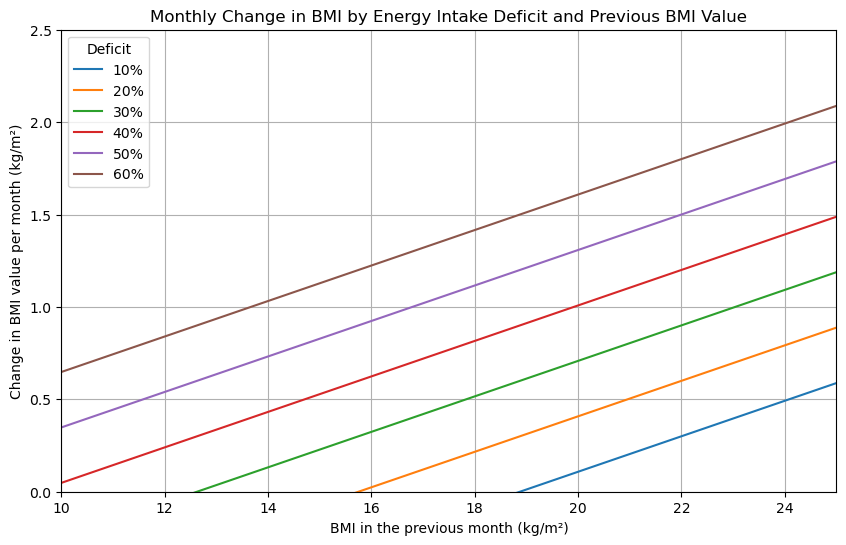

In [8]:
# Deficits to plot
deficits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
bmi_prev_values = np.linspace(10, 25, 100)

plt.figure(figsize=(10, 6))

# Plot each deficit line
for deficit in deficits:
    # Calculate the change in BMI (delta_bmi)
    bmi_changes = [bmi_prev - update_bmi(deficit, bmi_prev) for bmi_prev in bmi_prev_values]
    plt.plot(bmi_prev_values, bmi_changes, label=f'{int(deficit * 100)}%')

plt.xlabel('BMI in the previous month (kg/m²)')
plt.ylabel('Change in BMI value per month (kg/m²)')
plt.title('Monthly Change in BMI by Energy Intake Deficit and Previous BMI Value')

plt.xlim(10, 25)
plt.ylim(0, 2.5)  # Adjusted to include negative values
plt.grid(True)

plt.legend(title='Deficit')

plt.show()

In [9]:
# example - 30% deficit, initial BMI was 22, now BMI will go down to 21.1
update_bmi(0.3, 22)

21.1

## Change in BMI over time with constant caloric deficit

As in the Clingendael report, we consider the month-on-month changes in BMI with constant caloric deficits. Note that instead of assuming constant calories we assume a constant deficit (again, caloric intake requirements change as a function of BMI).

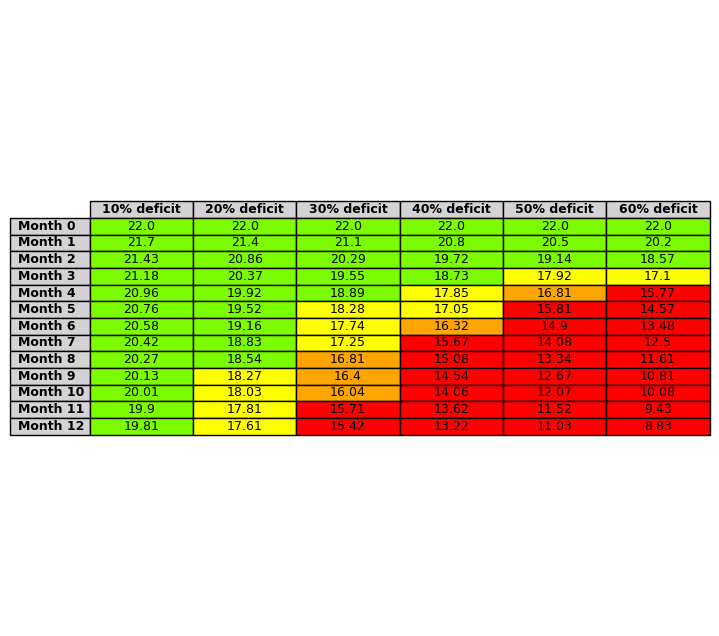

In [10]:
energy_deficits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]  # Positive values indicate deficits
months = range(0, 13)  # 12 months
start_bmi = 22.0

bmi_df = pd.DataFrame(index=months, columns=energy_deficits)

# Simulate BMI changes over 12 months for each energy deficit
for deficit in energy_deficits:
    bmi_values = []
    bmi = start_bmi
    for month in months:
        bmi_values.append(bmi)
        bmi = update_bmi(deficit, bmi, recovery=False)
    bmi_df[deficit] = bmi_values

def bmi_category(bmi):
    if bmi > 18.5:
        return 'Healthy'
    elif 17 < bmi <= 18.5:
        return 'Mild Thinness'
    elif 16 < bmi <= 17:
        return 'Moderate Thinness'
    else:
        return 'Severe Thinness'

bmi_categories_df = bmi_df.map(bmi_category)

category_colors = {
    'Healthy': '#7CFC00',          # Green
    'Mild Thinness': '#FFFF00',    # Yellow
    'Moderate Thinness': '#FFA500',# Orange
    'Severe Thinness': '#FF0000'   # Red
}

color_matrix = bmi_categories_df.replace(category_colors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('tight')
ax.axis('off')

table_data = bmi_df.round(2).values.tolist()

row_labels = ['Month {}'.format(i) for i in months]
col_labels = ['{}% deficit'.format(int(d*100)) for d in energy_deficits]

table = ax.table(cellText=table_data,
                     rowLabels=row_labels,
                     colLabels=col_labels,
                     cellLoc='center',
                     loc='center')



for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        # Header cells
        cell.set_text_props(weight='bold', color='black')
        cell.set_facecolor('#D3D3D3')  # Light gray
    else:
        bmi_value = bmi_df.iloc[row - 1, col]
        category = bmi_category(bmi_value)
        color = category_colors[category]
        cell.set_facecolor(color)


#plt.title('BMI Changes Over 12 Months for Various Energy Deficits')
#plt.tight_layout()
plt.show()

## Estimating excess mortality

At low levels of BMI, humans are more likely to die, reported as the probability of dying in that month given the last month's BMI:

\[
excess_mortality = 0.00023 * math.exp((18.5 - BMIt_minus_1) ** 1.36)
\]

In [11]:
# Look at a few example values of BMI:
[calculate_excess_mortality(x) for x in [ 16, 15.5, 15,14.5, 14]]

[0.007442998270129275,
 0.01980046900328039,
 0.05597354810308187,
 0.16717683895878668,
 0.5251574461419584]

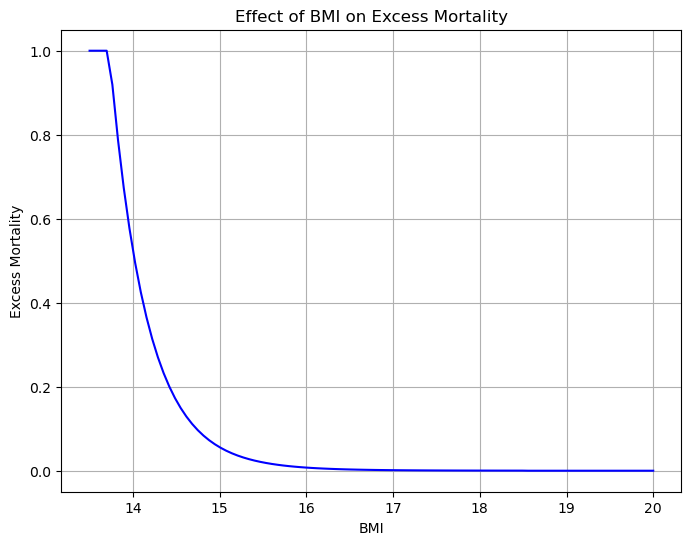

In [12]:
# Now let's plot across BMI values from 13.5 to 20
bmi_values = np.linspace(13.5, 20, 100)
mortality_values = [calculate_excess_mortality(bmi) for bmi in bmi_values]

plt.figure(figsize=(8, 6))
plt.plot(bmi_values, mortality_values, label="Excess Mortality", color='b')
plt.title("Effect of BMI on Excess Mortality")
plt.xlabel("BMI")
plt.ylabel("Excess Mortality")
plt.grid(True)
plt.show()

## Conclusion

### Caveats:
- How people respond to caloric deficits depends on a number of other factors, such as age, sex, activity level, sickness, etc. How people respond to an increase in calories after a deficit ("recovery") differs as well, which is omitted from above for simplicitly.
- Similarly, mortality levels depend not only on caloric intake but outbreak of communicable diseases, etc. which are exacerbated by malnourishment. The equation for this calculation is based on North American studies that might not apply correctly in other contexts.
